In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from itertools import chain
import json
from json import JSONDecodeError
import seaborn as sns
from scipy.stats import linregress
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel


def get_salience_df(name="results/salience_results_all_models.json", models=None, ds_names=None):
    salience_df = pd.read_json(name, orient="records", lines=True)
    if models:
        salience_df = salience_df[salience_df["model_name"].isin(models)]
    if ds_names:
        salience_df = salience_df[salience_df["ds_name"].isin(ds_names)]
    avgd_salience_df = salience_df.groupby(["ds_name", "against", "model_name"], as_index=False).mean(numeric_only=True)
    # pivot on "against"
    salience_df = avgd_salience_df.pivot(index=["ds_name", "model_name"], columns="against")
    # flatten the index
    salience_df.columns = ['_'.join(col).strip() for col in salience_df.columns.values]
    salience_df["weak_label_acc"] = salience_df["weak_label_acc_oracle"]
    salience_df["weak_label_auroc"] = salience_df["weak_label_auroc_oracle"]
    salience_df = salience_df.drop(columns=["weak_label_acc_oracle", "weak_label_auroc_oracle", "weak_label_acc_weak", "weak_label_auroc_weak"])
    return salience_df


def load_result(path):
    path = Path(path)
    try:
        with open(path / "results.json") as f:
            data = json.load(f)
        with open(path / "config.json") as f:
            config = json.load(f)
    except (FileNotFoundError, JSONDecodeError) as e:
        if isinstance(e, JSONDecodeError):
            print(f"Error decoding {path}: {e}")
        return
    
    if config["reporter"]["method"] == "ModularSftReporter":
        stages_cfg = config["reporter"]["stages"]
        weak_compute = sum(stage["num_weak_nonunique"] * stage["train_args"]["num_train_epochs"] for stage in stages_cfg)
        oracle_compute = sum(stage["num_oracle_nonunique"] * stage["train_args"]["num_train_epochs"] for stage in stages_cfg)
        total_compute = weak_compute + oracle_compute
    elif config["reporter"]["method"] == "FewShotPromptedSFTReporter":
        weak_compute = config["reporter"]["train_cfg"]["train_args"]["num_train_epochs"] * config["reporter"]["num_weak_nonunique"]
        oracle_compute = 0
        total_compute = weak_compute
    else:
        weak_compute, oracle_compute, total_compute = 0, 0, 0

    try:
        num_weak = data["num_weak"]
        num_oracle = data["num_oracle"]
        num_weak_nonunique = data["num_weak_nonunique"]
        num_oracle_nonunique = data["num_oracle_nonunique"]
    except KeyError as e:
        num_weak = data["reporter"]["num_weak"]
        num_oracle = data["reporter"]["num_oracle"]
        num_weak_nonunique = data["reporter"]["num_weak_nonunique"]
        num_oracle_nonunique = data["reporter"]["num_oracle_nonunique"]
    
    # oracle_cost = int(path.name.split("_")[0].split("=")[1]
    seed = int(path.name.split("_")[-1].split("s")[-1])
    if "m=" in path.name:
        sweep_name = "_".join(path.name.split("_")[3:-1])
    else:
        sweep_name = "_".join(path.name.split("_")[2:-1])
    return {
        "auroc": data["auroc"],
        "model_name": config["model"]["name"],
        "num_oracle": num_oracle,
        "num_weak": num_weak,
        "num_oracle_nonunique": num_oracle_nonunique,
        "num_weak_nonunique": num_weak_nonunique,
        "weak_compute": weak_compute,
        "oracle_compute": oracle_compute,
        "total_compute": total_compute,
        "seed": seed,
        "ds_name": path.parent.name,
        "sweep_name": sweep_name,
        "path": str(path),
    }


def get_results_df(ds_names=None, patterns=None):
    patterns = patterns or ["nw=*_seq_sft_both_estop_s*",]
    results = []
    if ds_names is None:
        ds_names = [d.name for d in Path("results").iterdir() if d.is_dir()]
    for ds_name in ds_names:
        for subdir in chain(*[Path(f"results/{ds_name}").glob(pattern) for pattern in patterns]):
            if result := load_result(subdir):
                results.append(result)
    results_df = pd.DataFrame(results)
    results_df.set_index(["ds_name", "model_name", "sweep_name"], inplace=True, drop=False)
    return results_df

reparam = "log({x} + 1)"
def reparametrize(x):
    x = np.asarray(x)
    if reparam == "log({x} + 1)":
        return np.log10(x + 1)
    elif reparam == "{x}":
        return x


In [25]:
# patterns = ["nw=*_seq_sft_both_estop_s*",]
# results = []
# ds_names = [d.name for d in Path("results").iterdir() if d.is_dir()]
# for ds_name in ds_names:
#     for subdir in chain(*[Path(f"results/{ds_name}").glob(pattern) for pattern in patterns]):
#         try:
#             with open(subdir / "stage1" / "best-ckpt" / "trainer_state.json", "r") as f:
#                 trainer_state = json.loads(f.read())
#             print(trainer_state["best_model_checkpoint"])
#         except Exception as e:
#             print(e)

In [26]:
# # rename bad runs
# sweep_name = "seq_sft_weak_estop_oracle_100x"
# replace_name = "100_steps_for_both"
# patt = f"nw=*_{sweep_name}_s*"
# ds_names = [d.name for d in Path("results").iterdir() if d.is_dir()]
# for ds_name in ds_names:
#     for subdir in chain(*[Path(f"results/{ds_name}").glob(patt)]):
#         # Rename the sweep directory
#         new_name = subdir.name.replace(sweep_name, replace_name)
#         new_path = subdir.parent / new_name
        
#         # Check if the new directory name already exists
#         if not new_path.exists():
#             subdir.rename(new_path)
#             print(f"Renamed: {subdir} -> {new_path}")
#         else:
#             print(f"Skipped renaming {subdir}: {new_path} already exists")
        


# Get weak label accuracies

In [98]:
from datasets import load_from_disk
from sklearn.metrics import roc_auc_score

base_ds_names = ds_names = [
    "boolq",
    # "anli-r2",
    # "ethics-virtue",
    # "ethics-utilitarianism",
    # "ethics-justice",
    # "ethics-deontology",
    "hellaswag",
    # "amazon_polarity",
    # "paws",
    # "sciq_with_support",
    "sciq",
    "cola",
    "cosmos_qa",
    "quail",
    # "social_i_qa",
    "dream",
]

weak_models = ["Qwen1.5-0.5B", "Qwen1.5-4B"]
weak_names = [f"{name}_{wm}" for name in base_ds_names for wm in weak_models]
# weak_names += [f"{wn}_shuffled_err" for wn in weak_names]
# weak_names += [f"{name}_{'Meta-Llama-3-8B'}_stopped_at_{wm}" for name in base_ds_names for wm in weak_models]

weak_accs = dict()
weak_aucs = dict()
for weak_name in weak_names:
    ds = load_from_disk(f"results/{weak_name}/weak_train")
    probs = np.array(ds["soft_pred"])[:, 1]
    labels = np.array(ds["hard_label"])
    auc = roc_auc_score(labels, probs)
    print(f"{weak_name}: {auc=:.3f} (n={len(ds)})")
    weak_aucs[weak_name] = float(auc)
    weak_accs[weak_name] = float(((probs > 0.5) == labels).mean())


boolq_Qwen1.5-0.5B: auc=0.754 (n=7106)
boolq_Qwen1.5-4B: auc=0.890 (n=7106)
hellaswag_Qwen1.5-0.5B: auc=0.737 (n=39842)
hellaswag_Qwen1.5-4B: auc=0.954 (n=39842)
sciq_Qwen1.5-0.5B: auc=0.851 (n=10674)
sciq_Qwen1.5-4B: auc=0.946 (n=10674)
cola_Qwen1.5-0.5B: auc=0.809 (n=5056)
cola_Qwen1.5-4B: auc=0.861 (n=5056)
cosmos_qa_Qwen1.5-0.5B: auc=0.869 (n=23788)
cosmos_qa_Qwen1.5-4B: auc=0.940 (n=23788)
quail_Qwen1.5-0.5B: auc=0.778 (n=10226)
quail_Qwen1.5-4B: auc=0.884 (n=10226)
dream_Qwen1.5-0.5B: auc=0.698 (n=6082)
dream_Qwen1.5-4B: auc=0.904 (n=6082)


# Get all the results interpolated over num weak and num oracle

In [99]:
# for what values of weak affordable, oracle affordable, weak quality, distractor salience, desired salience should you spend 100% of your budget on oracle labels?
# for this I need to:
#  - take each setting (ds_name; including runs with both configs) and compute the GPR fit
#  - choose a few reasonable values of weak affordable and oracle affordable
#  - sample a few AUROCs from the GP for each pair of weak affordable and oracle affordable for each num oracle 
#  - also get the means (store the samples and means in a dataframe)
#  - if exclusively using oracle labels has a higher mean AUROC than any other fraction, then we consider this optimal

In [100]:
from typing import Literal
from scipy import stats
import numpy as np

def sigmoid_sparse_range(start, end, approx_num_points):
    """
    We use this to sample numbers of points because we want more precision near the boundaries 
    where n_weak or n_oracle is small
    """
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    assert int(start) == start and int(end) == end, f"{start} and {end} must be integers"

    # Generate evenly spaced points in the range [-6, 6]
    x = np.linspace(-7, 7, approx_num_points)

    # Apply sigmoid function
    y = sigmoid(x)

    # Scale to desired range
    scaled = y * (end - start) + start

    # Round to nearest integer and remove duplicates
    result = np.unique(np.round(scaled).astype(int))

    # Ensure start and end are included
    if result[0] != start:
        result = np.insert(result, 0, start)
    if result[-1] != end:
        result = np.append(result, end)

    return result


def get_optimal_spending_frac(gp, weak_affordable=10_000, oracle_marginal_cost=10_000, oracle_fixed_cost=0, objective: Literal["mean", "10th"] = "mean", return_auroc=False):
    n_wo = []
    for n_weak in sigmoid_sparse_range(0, round(weak_affordable), 20):
        n_oracle = max(int((weak_affordable - n_weak - oracle_fixed_cost) / oracle_marginal_cost), 0)
        n_wo.append([n_weak, n_oracle])
    n_wo = np.array(n_wo)
    
    # note that it doesn't make sense to sample and then take argmaxes, 
    # because it heavily depends on variance and n
    auroc, auroc_std = gp.predict(reparametrize(n_wo), return_std=True)
    spent_oracle = n_wo[:, 1] * oracle_marginal_cost + np.where(n_wo[:, 1] > 0, oracle_fixed_cost, 0)
    spent_weak = n_wo[:, 0]
    # silence divide by 0 warnings
    with np.errstate(divide='ignore', invalid='ignore'):
        oracle_spending_fracs = np.where(spent_oracle + spent_weak > 0, spent_oracle / (spent_oracle + spent_weak), 0)
    if objective == "mean":
        idx = np.nanargmax(auroc)
        optimal_spending_frac = oracle_spending_fracs[idx]
        optimal_auroc = auroc[idx]
    elif objective == "10th":
        # we want a high bound on the 10th percentile of the distribution
        tenth_percentiles = [stats.norm.ppf(0.1, loc=mu, scale=std) for mu, std in zip(auroc, auroc_std)]
        idx = np.nanargmax(tenth_percentiles)
        optimal_spending_frac = oracle_spending_fracs[idx]
        optimal_auroc = auroc[idx]
    else:
        raise ValueError(f"Unknown objective: {objective}")
    
    if return_auroc:
        return optimal_spending_frac, optimal_auroc
    else:
        return optimal_spending_frac
        

result = sigmoid_sparse_range(0, int(1e2), 20)
print(result)

[  0   1   2   4   7  14  25  41  59  75  86  93  96  98  99 100]


In [101]:
sweep_names = ["seq_sft_both_estop", "w2s_then_lp_gt", "w2s_then_active_lp_gt", "seq_sft_both_estop_clean", "seq_sft_oracle_estop_5x", "seq_sft_weak_estop_oracle_active_100steps", "seq_sft_both_estop_active_oracle", "seq_sft_weak_estop_active_oracle_3x", "seq_sft_both_estop_clean_logconf", "few_shot_prompt", "few_shot_prompted_sft_estop"]
strong_name = "meta-llama/Meta-Llama-3-8B"
salience_df = get_salience_df(models=None, ds_names=None, name="results/salienceV2.json")
results_df = get_results_df(ds_names=None, patterns=[f"nw*_{sweep_name}_s*" for sweep_name in sweep_names])

In [102]:
from tqdm import tqdm
from sklearn.exceptions import ConvergenceWarning
import warnings

gp_models = []
for row_name in tqdm(results_df.index.unique(), total=len(results_df.index.unique())):

    ds_name, model_name, sweep_name = row_name
    curr_df = results_df[(results_df["ds_name"] == ds_name) & (results_df["model_name"] == model_name) & (results_df["sweep_name"] == sweep_name)]
    if len(curr_df) == 0:
        continue
    X_raw = np.stack([curr_df["num_weak"].values, curr_df["num_oracle"].values], axis=1)
    # we didn't actually run this run, but we know that if you train on 0 data you'd get 0.5 AUROC on average and we want our GP to reflect that
    X_raw = np.vstack([X_raw, np.zeros((1, 2))])
    X = reparametrize(X_raw)  # type: ignore
    y = curr_df["auroc"].values
    y = np.hstack([y, np.ones(1) / 2])

    kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds="fixed") + WhiteKernel(noise_level=0.1)
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=2, normalize_y=True)

    gp.fit(X, y)
    # try:
    #     with warnings.catch_warnings():
    #         warnings.filterwarnings("error")
    #         gp.fit(X, y)
    # except ConvergenceWarning:
    #     print(f"ConvergenceWarning for {ds_name} {model_name} {sweep_name}")
    #     print("X.shape", X.shape)
    #     continue

    row_data = {
        "ds_name": ds_name,
        "model_name": model_name,
        # "weak_label_auroc": row["weak_label_auroc"],
        # "weak_label_acc": row["weak_label_acc"],
        # "salience_weak": row["salience_weak"],
        # "salience_oracle": row["salience_oracle"],
        "sweep_name": sweep_name,
    }
    gp_models.append({
        "gp": gp,
        "X": X,
        "y": y,
        **row_data,
    })

    # if ds_name == "ethics-utilitarianism_Qwen1.5-0.5B" and len(curr_df) > 0:
        # break
        
gp_models = pd.DataFrame(gp_models).set_index(["ds_name", "model_name", "sweep_name"])


  0%|          | 0/139 [00:00<?, ?it/s]/home/alex/.conda/envs/w2s2/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/alex/.conda/envs/w2s2/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/alex/.conda/envs/w2s2/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
  2%|▏    

In [83]:
# all_df.to_pickle("results/optimal_spending_frac.pkl")
# gp_models.to_pickle("results/gp_models.pkl")

## GPR of particular dataset

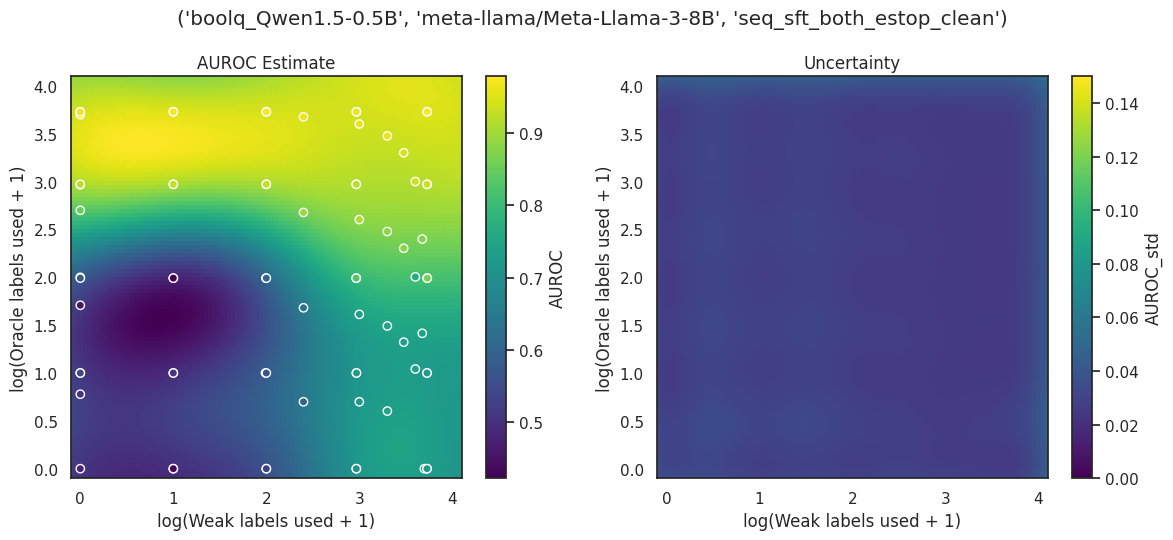

In [84]:
from matplotlib.colors import Normalize
import random
sns.set_theme(style="white")


base_ds_names = ["boolq", "hellaswag", "sciq"]
weak_model, strong_model = "Qwen1.5-0.5B", "meta-llama/Meta-Llama-3-8B"
# kinds = ["{base_name}_" + weak_model + "_shuffled_err", "{base_name}_" + weak_model, "{base_name}_" + strong_model.split('/')[-1] + "_stopped_at_" + weak_model]
kinds = ["{base_name}_" + weak_model,]
ds_names = [kind.format(base_name=base_ds_name) for base_ds_name in base_ds_names for kind in kinds]
ds_name = random.choice(ds_names)
row_name = run_name = (ds_name,
  'meta-llama/Meta-Llama-3-8B',
  'seq_sft_both_estop_clean'
)
row = gp_models.loc[row_name]
X, y, gp = row["X"], row["y"], row["gp"]
x_range = np.linspace(-0.1, 4.1, 100)
y_range = np.linspace(-0.1, 4.1, 100)
xx, yy = np.meshgrid(x_range, y_range)
Xgrid = np.vstack([xx.ravel(), yy.ravel()]).T

# Predict on the grid
Z, Z_std = gp.predict(Xgrid, return_std=True)  # type: ignore
Z, Z_std = Z.reshape(xx.shape), Z_std.reshape(xx.shape)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 5.5))
ax = axs[0]
im = ax.imshow(Z, extent=[x_range.min(), x_range.max(), y_range.min(), y_range.max()],
               origin='lower', aspect='auto', cmap='viridis')
ax.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolors='w')
plt.colorbar(im, label='AUROC')
ax.set_xlabel(reparam.format(x="Weak labels used"))
ax.set_ylabel(reparam.format(x="Oracle labels used"))
ax.set_title("AUROC Estimate")
ax = axs[1]
im = ax.imshow(Z_std, extent=[x_range.min(), x_range.max(), y_range.min(), y_range.max()],
               origin='lower', aspect='auto', cmap='viridis', norm=Normalize(0, 0.15))
plt.colorbar(im, label='AUROC_std')
ax.set_xlabel(reparam.format(x="Weak labels used"))
ax.set_ylabel(reparam.format(x="Oracle labels used"))
ax.set_title("Uncertainty")
plt.suptitle(f"{row_name}")
plt.tight_layout()
plt.show()

## Get a heatmap of optimal spending fraction
versus weak affordable and oracle marginal cost for each dataset, model, and oracle fixed cost

In [85]:
# makes a plot with 
# x=weak_affordable, y=oracle_affordable, and color=optimal_spending_frac as a heatmap/imshow

# get a grid of weak_affordable and oracle_marginal_cost
oracle_fixed_cost = 0
max_oracle_marginal_cost = 10_000
max_weak_affordable = 10_000
objective = "mean"
results = []
nx, ny = 10, 10
omcs, was = np.geomspace(1, max_oracle_marginal_cost, nx), np.geomspace(1, max_weak_affordable, ny)
grids = dict()
for row in gp_models.iloc:
    grids[row.name] = np.zeros((nx, ny))
    for i, oracle_marginal_cost in enumerate(omcs):
        for j, weak_affordable in enumerate(was):
            optimal_spending_frac = get_optimal_spending_frac(row["gp"], weak_affordable=weak_affordable, oracle_marginal_cost=oracle_marginal_cost, oracle_fixed_cost=oracle_fixed_cost, objective=objective)
            grids[row.name][i, j] = optimal_spending_frac
            results.append({
                "oracle_marginal_cost": oracle_marginal_cost,
                "weak_affordable": weak_affordable,
                "optimal_spending_frac": optimal_spending_frac,
                **row.to_dict(),
            })

heatmap_df = pd.DataFrame(results)


In [86]:
# all_df = pd.read_pickle("results/optimal_spending_frac.pkl")
# gp_models = pd.read_pickle("results/gp_models.pkl")

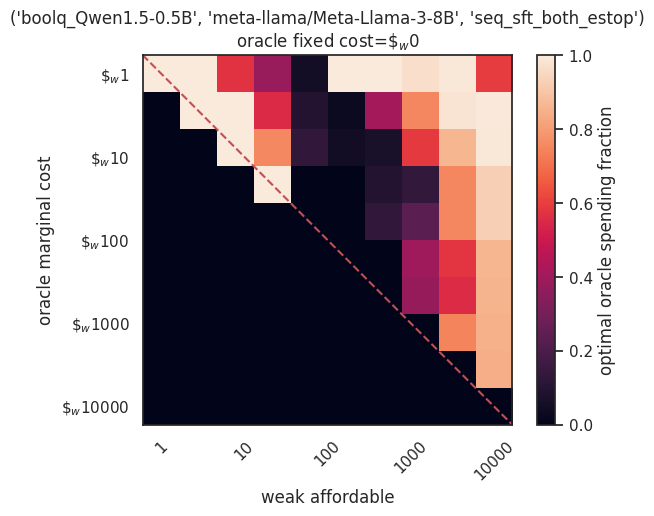

In [87]:
from matplotlib.colors import Normalize
run_name = (ds_name,
  strong_model,
  sweep_name)
plt.imshow(grids[run_name], norm=Normalize(0, 1))
plt.ylabel("oracle marginal cost")

# Select a subset of omcs and was for axis labels
num_ticks = 5
omc_ticks = np.geomspace(omcs[0], omcs[-1], num_ticks)
was_ticks = np.geomspace(was[0], was[-1], num_ticks)
plt.yticks(np.linspace(0, nx-1, num_ticks), [f"$\\$_w${x:.0f}" for x in omc_ticks])
plt.xticks(np.linspace(0, ny-1, num_ticks), [f"{x:.0f}" for x in was_ticks])
plt.xticks(rotation=45)

# draw y = x
plt.plot([-0.5, ny - 0.5], [-0.5, nx - 0.5], c="r", linestyle="--")

plt.title(f"{run_name}\noracle fixed cost=$\\$_w${oracle_fixed_cost}")

plt.xlabel("weak affordable")
plt.colorbar(label="optimal oracle spending fraction")
plt.show()

## Make a presentable AUROC vs spending frac figure (still using interpolation)

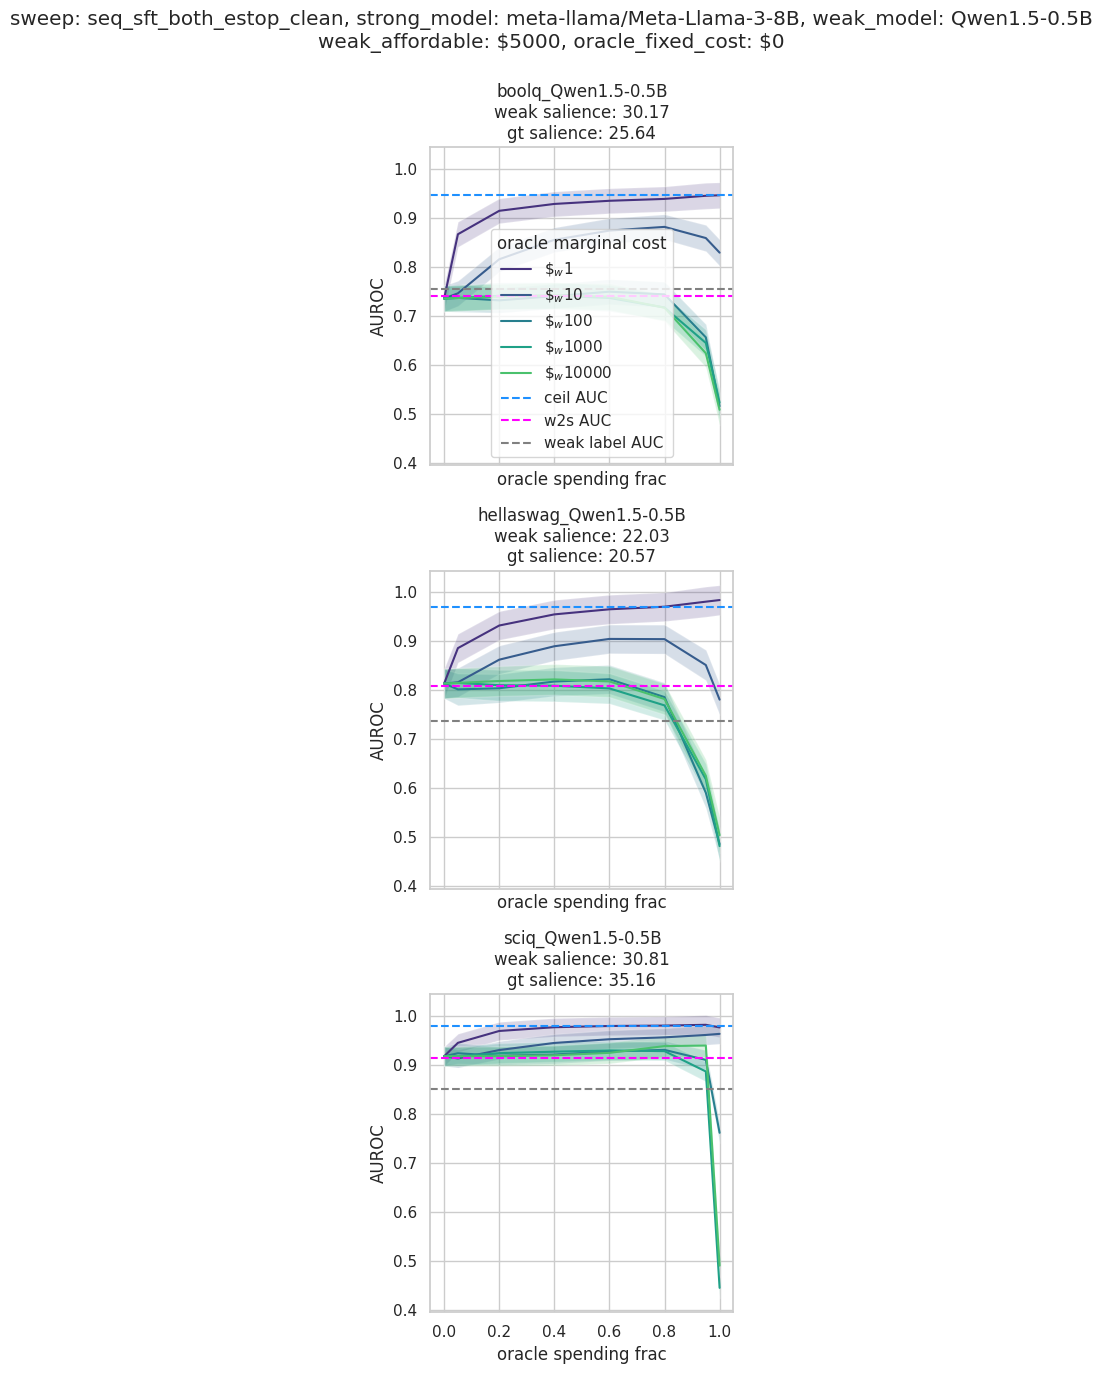

In [88]:
sns.set_theme(style="whitegrid")
sns.set_palette("viridis")
# Fix a budget (weak affordable), then show AUROC vs spending frac for various oracle costs
# Also include a ceiling line for 10,000 oracle examples, a weak label acc line, and a w2s line for 10,000 examples
# Do this for a few budgets, for each dataset (grouped by base dataset)

weak_affordable = 5000
weak_model = "Qwen1.5-0.5B"
strong_model = "meta-llama/Meta-Llama-3-8B"
# sweep_name = "seq_sft_both_estop"
# sweep_name = "w2s_then_lp_gt"
# sweep_name = "w2s_then_active_lp_gt"
sweep_name = "seq_sft_both_estop_clean"
# sweep_name = "seq_sft_oracle_estop_5x"
# sweep_name = "seq_sft_weak_estop_oracle_active_100steps"
# sweep_name = "seq_sft_both_estop_active_oracle"
# sweep_name = "seq_sft_weak_estop_active_oracle_3x"
oracle_fixed_cost = 0

oracle_spending_fracs = [0.0, 0.05, 0.2, 0.4, 0.6, 0.8, 0.95, 1.0] # np.linspace(0, 1, 11, endpoint=True)
oracle_marginal_costs = [1, 10, 100, 1000, 10_000]

base_ds_names = ["boolq", "hellaswag", "sciq"]
kinds = ["{base_name}_" + weak_model,]
# kinds = ["{base_name}_" + weak_model + "_shuffled_err", "{base_name}_" + weak_model, "{base_name}_" + strong_model.split('/')[-1] + "_stopped_at_" + weak_model]
fig, axs = plt.subplots(len(base_ds_names), len(kinds), figsize=(len(kinds) * 4, 2 + 4 * len(base_ds_names)), sharex=True, sharey=True)
axs = axs.reshape((len(base_ds_names), -1))
for i, base_ds_name in enumerate(base_ds_names):
    for j, kind in enumerate(kinds):
        plt.sca(axs[i, j])
        ds_name = kind.format(base_name=base_ds_name)
        run_name = (ds_name,
            strong_model,
            sweep_name)
        
        saliences = salience_df.loc[(ds_name, strong_model)]
        salience_weak, salience_oracle = saliences["salience_weak"], saliences["salience_oracle"]

        gp = gp_models.loc[run_name]["gp"]
        num_runs = len(gp_models.loc[run_name]["y"])
        if num_runs != 25:
            print(f"WARNING: {ds_name} has {num_runs} runs, expected 25")
        for omc in oracle_marginal_costs:
            aurocs = []
            auroc_stds = []
            for osf in oracle_spending_fracs:
                n_weak = int((1 - osf) * weak_affordable)
                maybe_oracle_fixed_cost = oracle_fixed_cost if osf > 0 else 0
                n_oracle = int(max(osf * weak_affordable - maybe_oracle_fixed_cost, 0) / omc)
                # print(f"({n_weak}, {n_oracle}),")
                auroc, auroc_std = gp.predict(reparametrize([[n_weak, n_oracle]]), return_std=True)
                aurocs.append(auroc.item())
                auroc_stds.append(auroc_std.item())
            plt.plot(oracle_spending_fracs, aurocs, label=f"$\\$_w{omc}$")
            plt.fill_between(oracle_spending_fracs, np.array(aurocs) - np.array(auroc_stds), np.array(aurocs) + np.array(auroc_stds), alpha=0.2)

        # get seq_sft_both_estop results for floor and w2s and ceiling
        idxer = (run_name[0], run_name[1], "seq_sft_both_estop_clean")
        X = gp_models.loc[idxer]["X"]
        y = gp_models.loc[idxer]["y"]
        # get ceiling
        # subject to nw = 0, get argmax no
        ceil_no = X[X[:, 0] == 0][:, 1].max()
        ceil_idx = np.where((X[:, 0] == 0) & (X[:, 1] == ceil_no))[0][0]
        ceil = y[ceil_idx]

        # get floor
        floor = saliences["weak_label_auroc"]

        # get w2s
        w2s_nw = X[X[:, 1] == 0][:, 0].max()
        w2s_idx = np.where((X[:, 0] == w2s_nw) & (X[:, 1] == 0))[0][0]
        w2s = y[w2s_idx]

        plt.axhline(ceil, linestyle="--", color="dodgerblue", label=f"ceil AUC") # ({round(10**ceil_no - 1)} oracle exs)")
        plt.axhline(w2s, linestyle="--", color="fuchsia", label=f"w2s AUC") # ({round(10**w2s_nw - 1)} weak exs)")
        plt.axhline(floor, linestyle="--", color="gray", label="weak label AUC")

        plt.xlabel("oracle spending frac")
        plt.ylabel("AUROC")
        plt.title(f"{ds_name}\nweak salience: {salience_weak:.2f}\ngt salience: {salience_oracle:.2f}")
        if i == 0 and j == 0:
            plt.legend(title="oracle marginal cost")
plt.suptitle(f"sweep: {sweep_name}, strong_model: {strong_model}, weak_model: {weak_model}\nweak_affordable: \\${weak_affordable}, oracle_fixed_cost: \\${oracle_fixed_cost}\n")
plt.tight_layout()
plt.show()

## Average over datasets

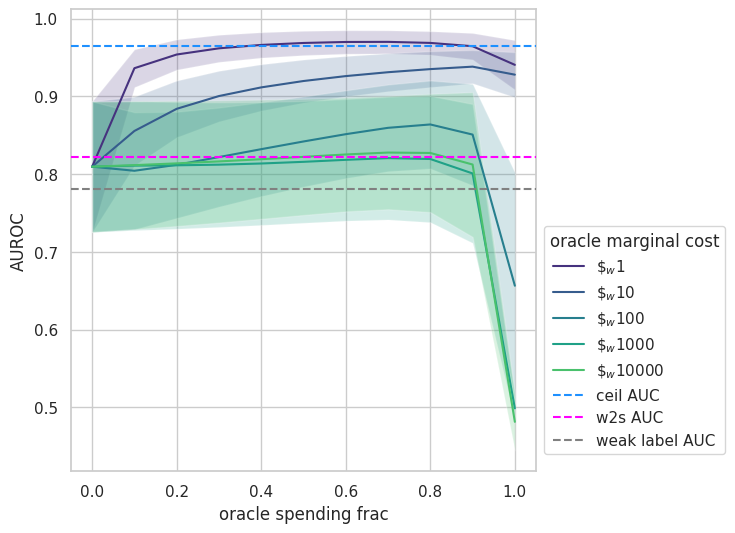

In [89]:

weak_affordable = 10000
weak_model = "Qwen1.5-0.5B"
strong_model = "meta-llama/Meta-Llama-3-8B"
# sweep_name = "seq_sft_both_estop"
# sweep_name = "w2s_then_lp_gt"
# sweep_name = "w2s_then_active_lp_gt"
sweep_name = "seq_sft_both_estop_clean"
# sweep_name = "seq_sft_oracle_estop_5x"
# sweep_name = "seq_sft_weak_estop_oracle_active_100steps"
# sweep_name = "seq_sft_both_estop_active_oracle"
# sweep_name = "seq_sft_weak_estop_active_oracle_3x"
oracle_fixed_cost = 0

oracle_spending_fracs = np.linspace(0, 1, 11, endpoint=True)
oracle_marginal_costs = [1, 10, 100, 1000, 10_000]


base_ds_names = ["boolq", "hellaswag", "sciq"]
kind = "{base_name}_" + weak_model

def avg_results_over_datasets(base_ds_names, kind, strong_model, sweep_name, oracle_fixed_cost, oracle_spending_fracs, oracle_marginal_costs, weak_affordable):
    results = []
    for i, base_ds_name in enumerate(base_ds_names):
        ds_name = kind.format(base_name=base_ds_name)
        run_name = (ds_name,
            strong_model,
            sweep_name)
        
        saliences = salience_df.loc[(ds_name, strong_model)]
        salience_weak, salience_oracle = saliences["salience_weak"], saliences["salience_oracle"]

        gp = gp_models.loc[run_name]["gp"]
        num_runs = len(gp_models.loc[run_name]["y"])
        if num_runs != 25:
            print(f"WARNING: {ds_name} has {num_runs} runs, expected 25")
        
        aurocs_by_omc = dict()
        for omc in oracle_marginal_costs:
            aurocs = []
            auroc_stds = []
            for osf in oracle_spending_fracs:
                n_weak = int((1 - osf) * weak_affordable)
                maybe_oracle_fixed_cost = oracle_fixed_cost if osf > 0 else 0
                n_oracle = int(max(osf * weak_affordable - maybe_oracle_fixed_cost, 0) / omc)
                auroc, auroc_std = gp.predict(reparametrize([[n_weak, n_oracle]]), return_std=True)
                aurocs.append(auroc.item())
                auroc_stds.append(auroc_std.item())
            aurocs_by_omc[omc] = np.array(aurocs)
        
        # get seq_sft_both_estop results for floor and w2s and ceiling
        idxer = (run_name[0], run_name[1], "seq_sft_both_estop_clean")
        X = gp_models.loc[idxer]["X"]
        y = gp_models.loc[idxer]["y"]
        # get ceiling
        # subject to nw = 0, get argmax no
        ceil_no = X[X[:, 0] == 0][:, 1].max()
        ceil_idx = np.where((X[:, 0] == 0) & (X[:, 1] == ceil_no))[0][0]
        ceil = y[ceil_idx]

        # get floor
        floor = saliences["weak_label_auroc"]

        # get w2s
        w2s_nw = X[X[:, 1] == 0][:, 0].max()
        w2s_idx = np.where((X[:, 0] == w2s_nw) & (X[:, 1] == 0))[0][0]
        w2s = y[w2s_idx]
        results.append({
            "ds_name": ds_name,
            "base_ds_name": base_ds_name,
            "kind": kind,
            "weak_model": weak_model,
            "strong_model": strong_model,
            "sweep_name": sweep_name,
            "salience_weak": salience_weak,
            "salience_oracle": salience_oracle,
            "aurocs_by_omc": aurocs_by_omc,
            "ceil": ceil,
            "w2s": w2s,
            "floor": floor,
        })


    # average over datasets
    auroc_means_by_omc = {}
    auroc_stds_by_omc = {}
    for omc in oracle_marginal_costs:
        aurocs = np.stack([r["aurocs_by_omc"][omc] for r in results])
        auroc_mean = aurocs.mean(axis=0)
        auroc_std = aurocs.std(axis=0)
        auroc_means_by_omc[omc] = auroc_mean
        auroc_stds_by_omc[omc] = auroc_std
    avg_ceil = np.mean([r["ceil"] for r in results])
    avg_w2s = np.mean([r["w2s"] for r in results])
    avg_floor = np.mean([r["floor"] for r in results])

    return auroc_means_by_omc, auroc_stds_by_omc, avg_ceil, avg_w2s, avg_floor

auroc_means_by_omc, auroc_stds_by_omc, avg_ceil, avg_w2s, avg_floor = avg_results_over_datasets(
    base_ds_names, kind, strong_model, sweep_name, oracle_fixed_cost, oracle_spending_fracs, oracle_marginal_costs, weak_affordable
)

plt.figure(figsize=(6, 6))
for omc in oracle_marginal_costs:
    auroc_mean = auroc_means_by_omc[omc]
    auroc_std = auroc_stds_by_omc[omc]
    plt.plot(oracle_spending_fracs, auroc_mean, label=f"$\\$_w{omc}$")
    plt.fill_between(oracle_spending_fracs, auroc_mean - auroc_std, auroc_mean + auroc_std, alpha=0.2)
plt.axhline(avg_ceil, linestyle="--", color="dodgerblue", label=f"ceil AUC", zorder=10)
plt.axhline(avg_w2s, linestyle="--", color="fuchsia", label=f"w2s AUC", zorder=10)
plt.axhline(avg_floor, linestyle="--", color="gray", label="weak label AUC", zorder=10)
plt.legend(title="oracle marginal cost", loc="lower left", bbox_to_anchor=(1, 0.02))
plt.xlabel("oracle spending frac")
plt.ylabel("AUROC")
# plt.title(f"{base_ds_names}\nweak salience: {salience_weak:.2f}\ngt salience: {salience_oracle:.2f}")
plt.show()

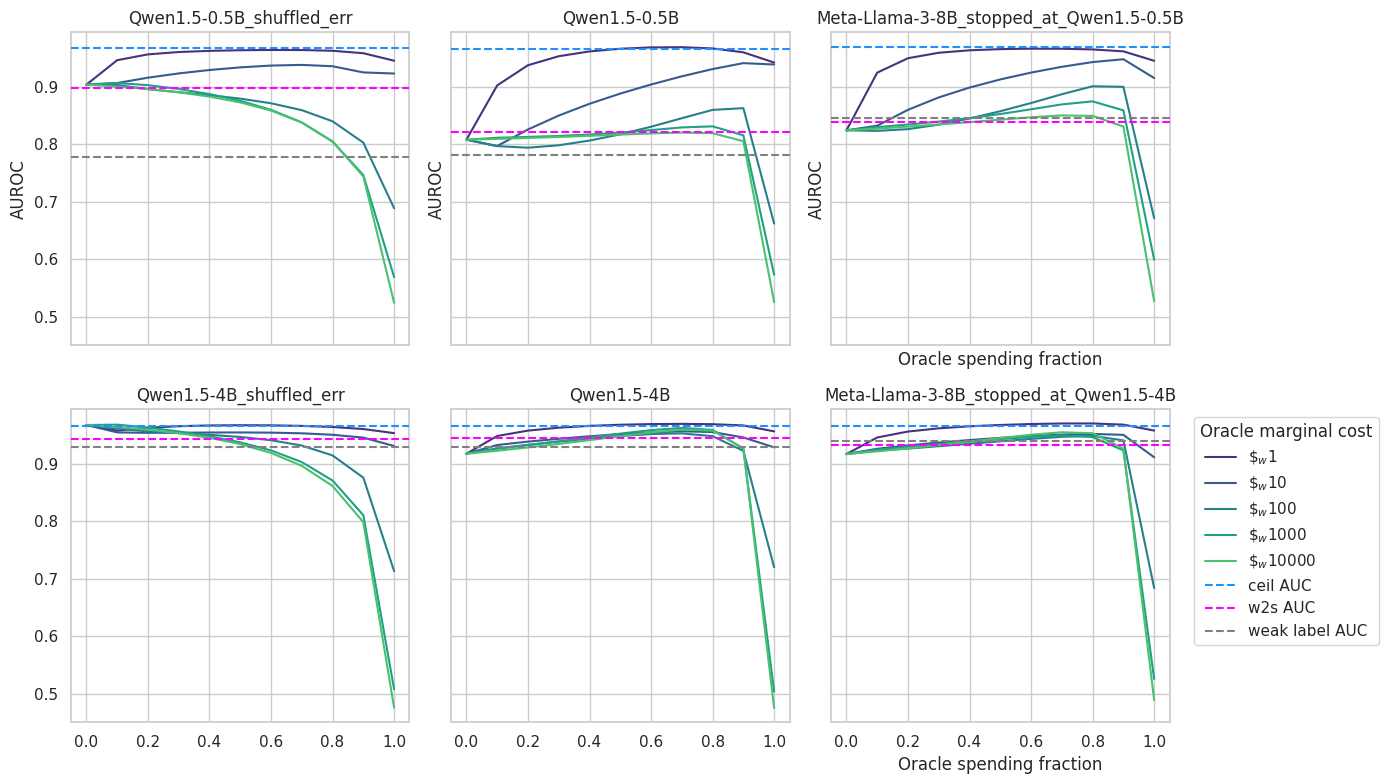

In [90]:
sweep_name = "seq_sft_both_estop"
weak_model_sizes = ["Qwen1.5-0.5B", "Qwen1.5-4B"]

fig, axs = plt.subplots(len(weak_model_sizes), 3, figsize=(12, 8), sharex=True, sharey=True)
for i, weak_model_size in enumerate(weak_model_sizes):
    kinds = ["{base_name}_" + weak_model_size + "_shuffled_err", "{base_name}_" + weak_model_size, "{base_name}_" + strong_model.split('/')[-1] + "_stopped_at_" + weak_model_size]
    for j, kind in enumerate(kinds):
        plt.sca(axs[i, j])
        auroc_means_by_omc, auroc_stds_by_omc, avg_ceil, avg_w2s, avg_floor = avg_results_over_datasets(
            base_ds_names, kind, strong_model, sweep_name, oracle_fixed_cost, oracle_spending_fracs, oracle_marginal_costs, weak_affordable
        )
        for omc in oracle_marginal_costs:
            auroc_mean = auroc_means_by_omc[omc]
            auroc_std = auroc_stds_by_omc[omc]
            axs[i, j].plot(oracle_spending_fracs, auroc_mean, label=f"$\\$_w{omc}$")
            # axs[i, j].fill_between(oracle_spending_fracs, auroc_mean - auroc_std, auroc_mean + auroc_std, alpha=0.2)
        
        axs[i, j].axhline(avg_ceil, linestyle="--", color="dodgerblue", label="ceil AUC", zorder=10)
        axs[i, j].axhline(avg_w2s, linestyle="--", color="fuchsia", label="w2s AUC", zorder=10)
        axs[i, j].axhline(avg_floor, linestyle="--", color="gray", label="weak label AUC", zorder=10)
        
        if j == len(kinds) - 1:
            axs[i, j].set_xlabel("Oracle spending fraction")
        if i == 0:
            axs[i, j].set_ylabel("AUROC")
        
        axs[i, j].set_title(kind.removeprefix("{base_name}_"))

plt.tight_layout()
plt.legend(title="Oracle marginal cost", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Cost, AUROC pareto curve
Cost to elicit 100% of ceil AUROC - or the whole cost, AUROC pareto curve for each method (a different subplot for each oracle marginal cost)

In [91]:
def find_result_by_n(n_weak, n_oracle, run_name, atol=0., rtol=0., verbose=True):
    curr_df = results_df.loc[run_name]
    curr_df = curr_df[np.isclose(curr_df["num_oracle"], n_oracle, atol=atol, rtol=rtol)]
    curr_df = curr_df[np.isclose(curr_df["num_weak"], n_weak, atol=atol, rtol=rtol)]
    if len(curr_df) == 0:
        if verbose:
            print(f"WARNING: {run_name} has no results for ({n_weak}, {n_oracle})")
        return
    elif len(curr_df) > 1 and verbose:
        print(f"WARNING: {run_name} has {len(curr_df)} results for ({n_weak}, {n_oracle}), using their mean")
    return curr_df["auroc"].mean()

/tmp/ipykernel_3540523/2410144230.py:43: PerformanceWarning: indexing past lexsort depth may impact performance.
  curr_df = results_df.loc[(kind.format(base_name=base_ds_names[0]), strong_model, sweep)]
/tmp/ipykernel_3540523/1686240705.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  curr_df = results_df.loc[run_name]
/tmp/ipykernel_3540523/2410144230.py:43: PerformanceWarning: indexing past lexsort depth may impact performance.
  curr_df = results_df.loc[(kind.format(base_name=base_ds_names[0]), strong_model, sweep)]
/tmp/ipykernel_3540523/1686240705.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  curr_df = results_df.loc[run_name]
/tmp/ipykernel_3540523/2410144230.py:43: PerformanceWarning: indexing past lexsort depth may impact performance.
  curr_df = results_df.loc[(kind.format(base_name=base_ds_names[0]), strong_model, sweep)]
/tmp/ipykernel_3540523/1686240705.py:2: PerformanceWarning: indexing past lexsort depth ma

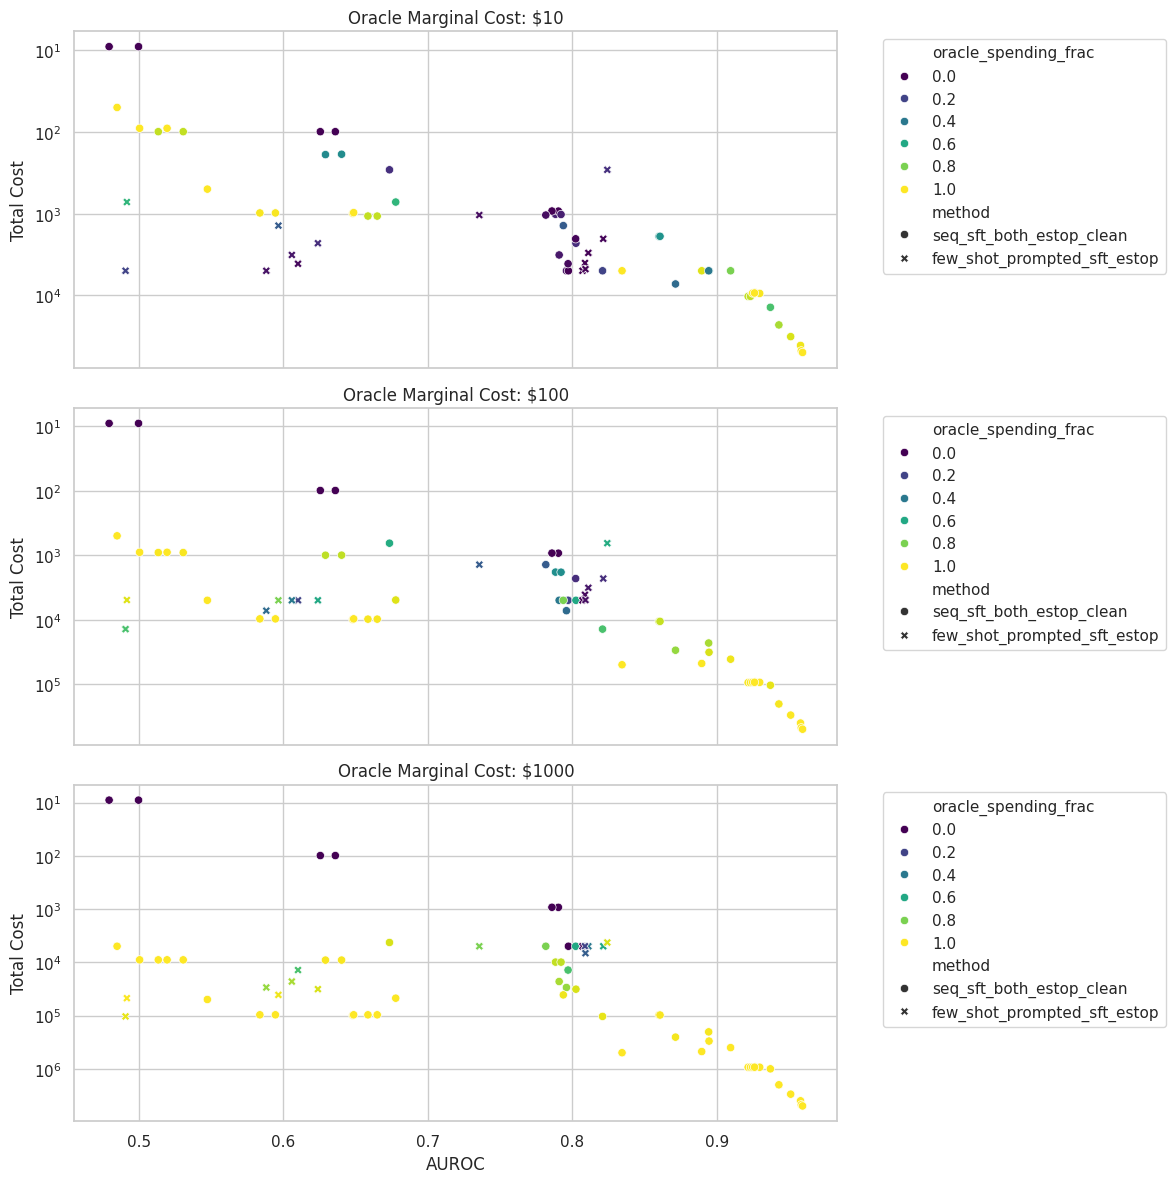

In [96]:
# I want a pareto curve. Each point shows the cheapest cost at which you can attain that AUC,
# or the highest AUC you can attain with that cost
# Fix an oracle marginal cost
# For each method (sweep name), get a linspace of 10 costs between 1 and the most expensive actual run
# Get the optimal spending frac and corresponding AUROC for each of those, based on average results over datasets
# Make a scatterplot of those points on x=cost, y=AUROC
# Color by spending frac
# Marker by method
import seaborn as sns
import pandas as pd
import numpy as np
sns.set_theme(style="whitegrid")
sns.set_palette("viridis")

oracle_marginal_costs = [10, 100, 1000]
base_ds_names = ["boolq", "hellaswag", "sciq"]  # NOTE
kind = "{base_name}_Qwen1.5-0.5B"
strong_model = "meta-llama/Meta-Llama-3-8B"
oracle_fixed_cost = 0
oracle_spending_fracs = np.linspace(0, 1, 20)

# Set up the plot
fig, axs = plt.subplots(len(oracle_marginal_costs), 1, figsize=(12, 4*len(oracle_marginal_costs)), sharex=True)
if len(oracle_marginal_costs) == 1:
    axs = [axs]

for idx, omc in enumerate(oracle_marginal_costs):
    results = []
    
    for sweep in ["seq_sft_both_estop_clean", "few_shot_prompted_sft_estop"]:
        max_cost = 10_000 * omc  # NOTE
        costs = np.geomspace(1, max_cost, 20)
        
        avg_ceil = None
        avg_w2s = None
        avg_floor = None
        cheapest_oracle_only_ceil = None
        cheapest_ceil_auc = None
        
        # iterate over datasets, getting individual points
        # get the set of all (num_weak, num_oracle) pairs for which all datasets have nearby data
        # To do this, pick one dataset, and for each pair, find all the pairs in each other dataset
        curr_df = results_df.loc[(kind.format(base_name=base_ds_names[0]), strong_model, sweep)]
        for row in curr_df.iloc:
            num_oracle = row["num_oracle"]
            num_weak = row["num_weak"]
            aurocs = [row["auroc"]]
            for other_ds_name in base_ds_names:
                if other_ds_name == row["ds_name"]:
                    continue
                other_run_name = (kind.format(base_name=other_ds_name), strong_model, sweep)
                auroc = find_result_by_n(num_weak, num_oracle, other_run_name, atol=0.01, rtol=0.05, verbose=False)
                if auroc is not None:
                    aurocs.append(auroc)
            if len(aurocs) < len(base_ds_names):
                continue
            oracle_spent = num_oracle * omc + int(num_oracle > 0) * oracle_fixed_cost
            weak_spent = num_weak
            spending_frac = oracle_spent / (oracle_spent + weak_spent)
            auroc_means = auroc_means_by_omc[omc]
            
            results.append({
                'method': sweep,
                'cost': oracle_spent + weak_spent,
                'oracle_spending_frac': spending_frac,
                'auroc': np.mean(aurocs),
            })
    
    df = pd.DataFrame(results)

    # floor
    avg_floor = np.mean([weak_aucs[kind.format(base_name=base_name)] for base_name in base_ds_names])
    
    # Create the scatter plot
    sns.scatterplot(data=df, y='cost', x='auroc', hue='oracle_spending_frac', 
                    style='method', palette='viridis', ax=axs[idx])
    
    plt.sca(axs[idx])
    axs[idx].set_title(f'Oracle Marginal Cost: ${omc}')
    axs[idx].set_ylabel('Total Cost')
    axs[idx].invert_yaxis()
    axs[idx].set_xlabel('AUROC')

    # plt.axvline(avg_ceil, linestyle="--", color="dodgerblue", label="ceil AUC", zorder=10)
    # plt.axvline(avg_w2s, linestyle="--", color="fuchsia", label="w2s AUC", zorder=10)
    # plt.axvline(avg_floor, linestyle="--", color="gray", label="weak label AUC", zorder=10)  # NOTE: it's a bit misleading to put this on the same axis since it was measured on a different set
    # plt.scatter(cheapest_ceil_auc, cheapest_oracle_only_ceil, color="red", label="oracle only ceil", zorder=10, s=100, marker="X")
    plt.semilogy()
    # Move the legend outside the plot
    axs[idx].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()



# AUROC vs spending frac for actual runs (no interpolation)

/tmp/ipykernel_3198503/1299293378.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  curr_df = results_df.loc[run_name]


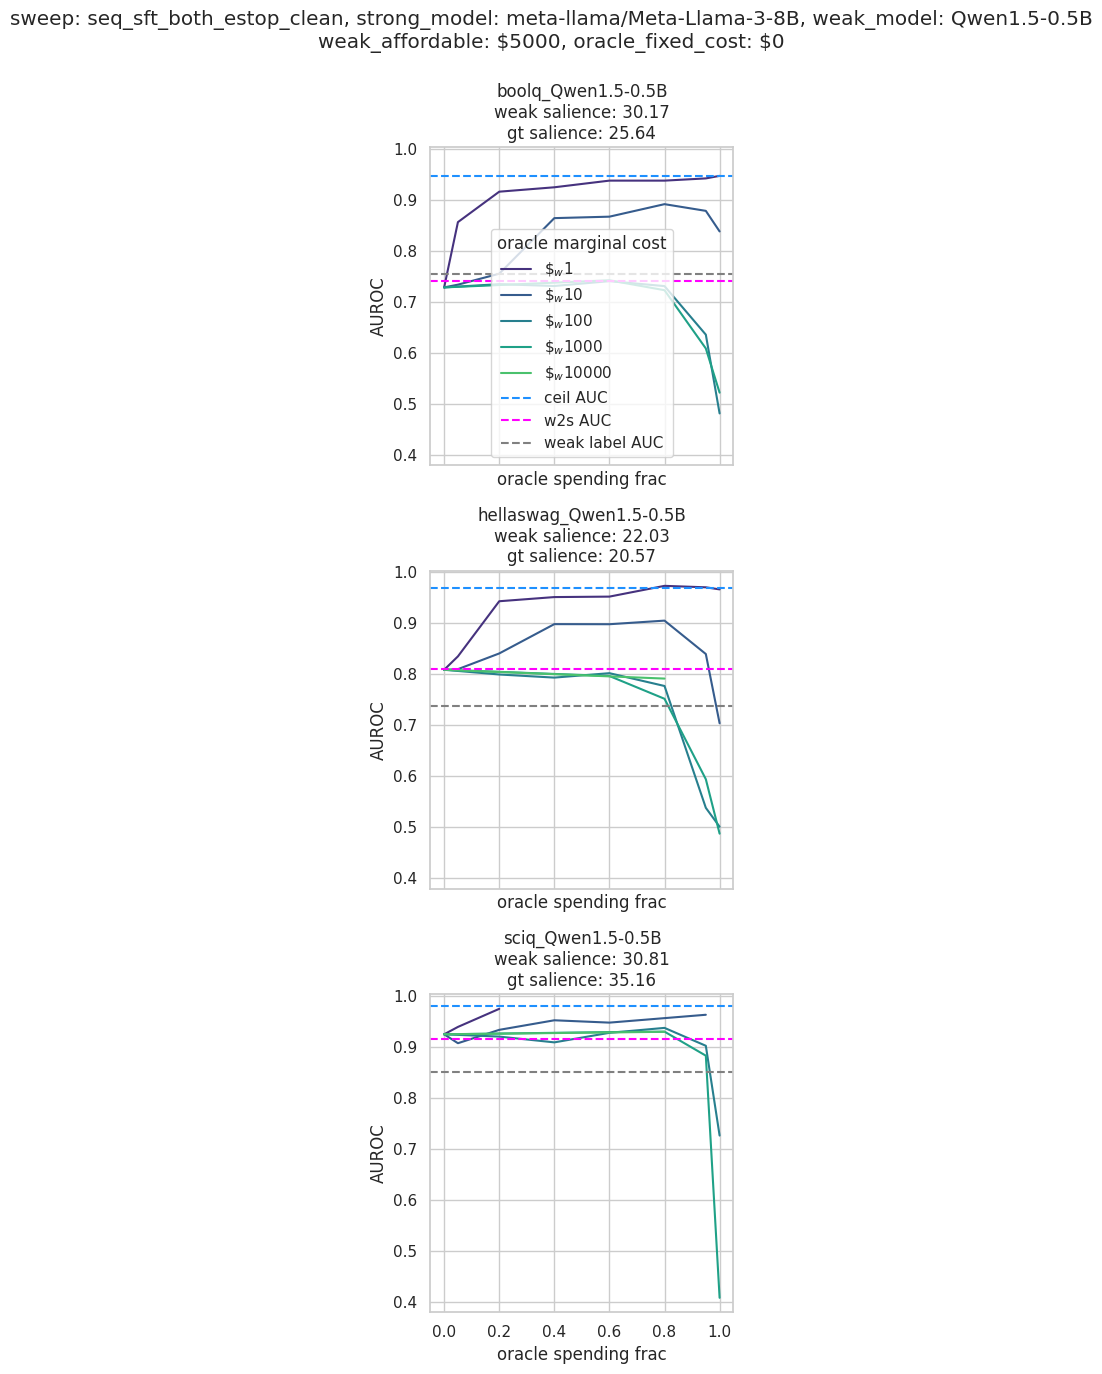

In [53]:
sns.set_theme(style="whitegrid")
sns.set_palette("viridis")

weak_affordable = 5000
weak_model = "Qwen1.5-0.5B"
strong_model = "meta-llama/Meta-Llama-3-8B"
sweep_name = "seq_sft_both_estop_clean"
oracle_fixed_cost = 0

oracle_spending_fracs = [0.0, 0.05, 0.2, 0.4, 0.6, 0.8, 0.95, 1.0] # np.linspace(0, 1, 11, endpoint=True)
oracle_marginal_costs = [1, 10, 100, 1000, 10_000]

base_ds_names = ["boolq", "hellaswag", "sciq"]
kinds = ["{base_name}_" + weak_model,]
# kinds = ["{base_name}_" + weak_model + "_shuffled_err", "{base_name}_" + weak_model, "{base_name}_" + strong_model.split('/')[-1] + "_stopped_at_" + weak_model]
fig, axs = plt.subplots(len(base_ds_names), len(kinds), figsize=(len(kinds) * 4, 2 + 4 * len(base_ds_names)), sharex=True, sharey=True)
axs = axs.reshape((len(base_ds_names), -1))
for i, base_ds_name in enumerate(base_ds_names):
    for j, kind in enumerate(kinds):
        plt.sca(axs[i, j])
        ds_name = kind.format(base_name=base_ds_name)
        run_name = (ds_name,
            strong_model,
            sweep_name)
        
        saliences = salience_df.loc[(ds_name, strong_model)]
        salience_weak, salience_oracle = saliences["salience_weak"], saliences["salience_oracle"]
        
        for omc in oracle_marginal_costs:
            aurocs = []
            used_oracle_spending_fracs = []
            for osf in oracle_spending_fracs:
                n_weak = int((1 - osf) * weak_affordable)
                maybe_oracle_fixed_cost = oracle_fixed_cost if osf > 0 else 0
                n_oracle = int(max(osf * weak_affordable - maybe_oracle_fixed_cost, 0) / omc)
                # print(f"({n_weak}, {n_oracle}),")
                auroc = find_result_by_n(n_weak, n_oracle, run_name, rtol=0.05)
                if auroc is not None:
                    aurocs.append(auroc)
                    used_oracle_spending_fracs.append(osf)
                
            plt.plot(used_oracle_spending_fracs, aurocs, label=f"$\\$_w{omc}$")
            

        # get seq_sft_both_estop results for floor and w2s and ceiling
        idxer = (run_name[0], run_name[1], "seq_sft_both_estop_clean")
        X = gp_models.loc[idxer]["X"]
        y = gp_models.loc[idxer]["y"]
        # get ceiling
        # subject to nw = 0, get argmax no
        ceil_no = X[X[:, 0] == 0][:, 1].max()
        ceil_idx = np.where((X[:, 0] == 0) & (X[:, 1] == ceil_no))[0][0]
        ceil = y[ceil_idx]

        # get floor
        floor = saliences["weak_label_auroc"]

        # get w2s
        w2s_nw = X[X[:, 1] == 0][:, 0].max()
        w2s_idx = np.where((X[:, 0] == w2s_nw) & (X[:, 1] == 0))[0][0]
        w2s = y[w2s_idx]

        plt.axhline(ceil, linestyle="--", color="dodgerblue", label=f"ceil AUC") # ({round(10**ceil_no - 1)} oracle exs)")
        plt.axhline(w2s, linestyle="--", color="fuchsia", label=f"w2s AUC") # ({round(10**w2s_nw - 1)} weak exs)")
        plt.axhline(floor, linestyle="--", color="gray", label="weak label AUC")

        plt.xlabel("oracle spending frac")
        plt.ylabel("AUROC")
        plt.title(f"{ds_name}\nweak salience: {salience_weak:.2f}\ngt salience: {salience_oracle:.2f}")
        if i == 0 and j == 0:
            plt.legend(title="oracle marginal cost")
plt.suptitle(f"sweep: {sweep_name}, strong_model: {strong_model}, weak_model: {weak_model}\nweak_affordable: \\${weak_affordable}, oracle_fixed_cost: \\${oracle_fixed_cost}\n")
plt.tight_layout()
plt.show()


# Parallel lines plot

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def parallel_lines_chart(data, feature_names, class_labels=None, colors=None, jitter=0.):
    """
    Create a parallel lines chart.
    
    :param data: 2D array where each row is an instance and each column a feature
    :param feature_names: List of feature names
    :param class_labels: List of class labels for each instance (optional)
    :param colors: List of colors for each class (optional)
    """
    fig, ax = plt.subplots(figsize=(12, 6))

    # Number of features
    num_features = data.shape[1]

    # Create x-axis points for each feature
    x = list(range(num_features))

    # Plot each instance
    for i, instance in enumerate(data):
        if class_labels is not None and colors is not None:
            color = colors[class_labels[i]]
        else:
            color = 'gray'
        
        jit = np.random.uniform(-jitter, jitter, num_features)
        ax.plot(x, instance + jit, c=color, alpha=0.3)

    # Set x-ticks and labels
    ax.set_xticks(x)
    ax.set_xticklabels(feature_names)
    # rotate
    plt.xticks(rotation=45, ha="right")

    # Set y-axis limits
    ax.set_ylim(data.min().min(), data.max().max())

    # Add a legend if class labels are provided
    if class_labels is not None and colors is not None:
        unique_labels = np.unique(class_labels)
        legend_elements = [plt.Line2D([0], [0], color=colors[label], label=label) 
                           for label in unique_labels]
        ax.legend(handles=legend_elements)

    plt.title('Parallel Lines Chart')
    plt.tight_layout()
    plt.show()

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import scipy.stats as stats

# Assuming all_df is your DataFrame
# If it's not defined, you need to load your data into all_df

# Prepare the data
X = all_df[["weak_label_auroc", "log_weak_affordable", "log_oracle_affordable", "salience_weak", "salience_oracle"]]
# X = all_df[["weak_label_auroc", "log_weak_affordable", "log_oracle_affordable", "salience_weak", "salience_oracle"]]
y = all_df["optimal_spending_frac"]

# Statsmodels regression (for detailed statistics)
X_sm = sm.add_constant(X)  # Add a constant term to the independent variables
model = sm.OLS(y, X_sm).fit()

# Print the summary of the regression
print(model.summary())

# Calculate VIF for each independent variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_sm.columns
vif_data["VIF"] = [variance_inflation_factor(X_sm.values, i) for i in range(X_sm.shape[1])]
print("\nVariance Inflation Factors:")
print(vif_data)

# Residual analysis
residuals = model.resid
fitted_values = model.fittedvalues

# Plot residuals vs fitted values
plt.figure(figsize=(10, 6))
plt.scatter(fitted_values, residuals)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

# Normal Q-Q plot of residuals
fig, ax = plt.subplots(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=ax)
ax.set_title("Normal Q-Q plot")
plt.show()

# Sklearn regression (for coefficients)
lr = LinearRegression()
lr.fit(X, y)
print("\nSklearn Coefficients:")
for name, coef in zip(X.columns, lr.coef_):
    print(f"{name}: {coef}")

In [ ]:
# linear regressiong of optimal spending frac on weak quality
l = linregress(all_df["weak_label_auroc"], all_df["optimal_spending_frac"])
plt.scatter(all_df["weak_label_auroc"], all_df["optimal_spending_frac"])
plt.plot([0, 1], [l.intercept, l.intercept + l.slope], color="red")

plt.xlabel("weak quality")
plt.ylabel("optimal spending frac")
l

## Cross-sectional results

In [ ]:
from typing import Literal
from collections import defaultdict

def get_cross_sectional_results(gp_df, kind: Literal["fixed_oracle", "fixed_weak", "equicompute"], intercept: int, n_samples=11):
    results = defaultdict(list)
    for row in gp_df.iloc:
        if kind == "fixed_oracle":
            n_wo = np.stack([np.linspace(0, 1e4, n_samples), np.array([intercept] * n_samples)], axis=1)
        elif kind == "fixed_weak":
            n_wo = np.stack([np.array([intercept] * n_samples), np.linspace(0, 1e4, n_samples)], axis=1)
        elif kind == "equicompute":
            n_wo = np.stack([np.linspace(0, intercept, n_samples), np.linspace(intercept, 0, n_samples)], axis=1)
        else:
            raise ValueError(f"Unknown kind: {kind}")

        mean, std = row["gp"].predict(reparametrize(n_wo), return_std=True)
        results["ds_name"].extend([row["ds_name"]] * n_samples)
        results["model_name"].extend([row["model_name"]] * n_samples)
        results["kind"].extend([kind] * n_samples)
        results["sweep_name"].extend([row["sweep_name"]] * n_samples)
        results["intercept"].extend([intercept] * n_samples)
        results["num_weak"].extend(n_wo[:, 0])
        results["num_oracle"].extend(n_wo[:, 1])
        results["auroc"].extend(mean)
        results["auroc_std"].extend(std)

    return pd.DataFrame(results)
    
sns.set_theme(style="whitegrid")
fig, axs = plt.subplots(3, 4, figsize=(30, 16), sharey=True, sharex=False)
for i, kind in enumerate(["fixed_oracle", "fixed_weak", "equicompute"]):
    for j, intercept in enumerate([10, 100, 1000, 10_000]):
        df = get_cross_sectional_results(gp_models, kind, intercept)
        plt.sca(axs[i, j])
        for sweep_name in ["seq_sft", "salience_cfg0"]:
            plot_df = df[df["sweep_name"] == sweep_name]
            sns.scatterplot(x="num_weak" if kind == "fixed_oracle" else "num_oracle", y="auroc", hue="ds_name", data=plot_df, marker="o" if sweep_name == "seq_sft" else "x", legend=i == 1 and j == 3 and sweep_name == "seq_sft")
            if i == 1 and j == 3 and sweep_name == "seq_sft":
                plt.legend(bbox_to_anchor=(1,0), loc="lower left", ncol=1)
        
        
        axs[i, j].set_title(f"{kind} - {intercept}")
# Add legend entries for x and o markers
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='gray', label='seq_sft', markerfacecolor='gray', markersize=10),
    plt.Line2D([0], [0], marker='x', color='gray', label='salience_cfg0', markerfacecolor='gray', markersize=10)
]

# Add the legend to the last subplot
axs[-1, -1].legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust the layout to make room for the legend
plt.tight_layout()
fig.subplots_adjust(right=0.85)

plt.show()

In [ ]:
plot_df

# Equi-cost curves

In [ ]:
df = None

In [ ]:
import numpy as np
from matplotlib.colors import Normalize, LinearSegmentedColormap
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

# ds_name = "boolq_Qwen1.5-0.5B"
ds_name = "amazon_polarity_title_only_gt_amplified"
plot_df = df[df["ds_name"] == ds_name]
min_auroc = round(plot_df["auroc"].quantile(0.25), 2)
max_auroc = round(plot_df["auroc"].max(), 2)
# Create a scatter plot with total_spent on x-axis and oracle_cost on y-axis
jitter = 0.0
norm = Normalize(vmin=min_auroc, vmax=max_auroc)
colors = plt.cm.viridis(np.linspace(0, 1, 256))
n_bins = 256
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=n_bins)
cmap.set_under('black')
scatter = ax.scatter((plot_df['num_weak'] + 1) * np.random.normal(1, jitter, len(plot_df)), (plot_df['num_oracle'] + 1) * np.random.normal(1, jitter, len(plot_df)), c=plot_df['auroc'], cmap=cmap, s=100, norm=norm, alpha=0.7)
plt.plot([0, 9000], [0, 9000], color="gray", linestyle="--", alpha=0.5, linewidth=0.5)

cmap = LinearSegmentedColormap.from_list('gray_to_red', ["gray", "red"], N=256)
crs = [10, 100, 1000]
for cost_ratio in crs:
    # color should be near gray if log(cr) is small, and near red if log(cr) is large
    color = (np.log(cost_ratio) - min(map(np.log, crs))) / (max(map(np.log, crs)) - min(map(np.log, crs))) 
    print(color)
    color = cmap(color)
    for oint in [10, 30, 100, 300, 1000, 3000, 10_000]:
        plt.plot(np.linspace(oint * cost_ratio + 1, 1, 101), np.linspace(1, oint, 101), color=color, linestyle="-", label=f"equibudget - {cost_ratio}:1 cost ratio" if oint == 10 else None)
plt.legend()

# Set labels and title
ax.set_xlabel("How many $\\bf{weak}$ labels were $\\bf{used}$")
ax.set_ylabel("How many $\\bf{oracle}$ labels were $\\bf{used}$")
ax.set_title(f"{ds_name}")

plt.loglog()
# replace tick labels with 10^i - 1
ticks = [1, 10, 100, 1000, 10000]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels([f"$10^{int(np.log10(tick))}$ - 1" for tick in ticks])
ax.set_yticklabels([f"$10^{int(np.log10(tick))}$ - 1" for tick in ticks])
ax.set_xlim(0.7, 12_000)
ax.set_ylim(0.7, 12_000)

cbar = plt.colorbar(scatter)
cbar.set_label('AUROC')

ax.grid(True, linestyle='--', alpha=0.7, linewidth=0.5)

plt.tight_layout()
plt.show()


# Quantization

In [ ]:
import wandb
import pandas as pd 
import wandb
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("eleutherai/huggingface")
runs_by_name = {run.name: run for run in runs}

run_names = [
    "amazon_polarity_Meta-Llama-3-8B_s1_quant",
    "amazon_polarity_Meta-Llama-3-8B_s1",
    "boolq_Meta-Llama-3-8B_s1_quant",
    "boolq_Meta-Llama-3-8B_s1",
    "amazon_polarity_Meta-Llama-3-8B_s2_quant",
    "amazon_polarity_Meta-Llama-3-8B_s2",
    "boolq_Meta-Llama-3-8B_s2_quant",
    "boolq_Meta-Llama-3-8B_s2",
    "amazon_polarity_Qwen1.5-7B_s1_quant",
    "amazon_polarity_Qwen1.5-7B_s1",
    "boolq_Qwen1.5-7B_s1_quant",
    "boolq_Qwen1.5-7B_s1",
    "amazon_polarity_Qwen1.5-7B_s2_quant",
    "amazon_polarity_Qwen1.5-7B_s2",
    "boolq_Qwen1.5-7B_s2_quant",
    "boolq_Qwen1.5-7B_s2",
]

In [ ]:
runs = {run_name: runs_by_name[run_name] for run_name in run_names}
runs

In [ ]:
import random
run_name = random.choice(list(runs.keys()))
run_name = run_name.replace("_quant", "")  # if it exists
quant_run_name = run_name + "_quant"
quant_run = runs[quant_run_name]
run = runs[run_name]

# Salience

In [ ]:
import pandas as pd 
import wandb
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("eleutherai/huggingface")
runs_by_name = {run.name: run for run in runs}

In [ ]:
import numpy as np
from scipy import integrate

def compute_auc(run):
    
    # Extract the eval/test_loss history
    history = run.scan_history(keys=["eval/test_loss", "train/global_step", "eval/test_auroc"])
    losses = [row["eval/test_loss"] for row in history]
    steps = [row["train/global_step"] for row in history]
    aurocs = [row["eval/test_auroc"] for row in history]
    try:
        batch_size = run.config.get("per_device_train_batch_size") * run.config.get("gradient_accumulation_steps")
    except TypeError:
        print(f"Run '{run.name}' does not have the necessary config values for AUC calculation.")
        return
    
    if isinstance(losses, list) and len(losses) > 1:
        aurocs = np.array(aurocs)
        near_max_idxs = np.nonzero(aurocs > 0.5 + 0.95 * (aurocs.max() - 0.5))
        first_good_idx = near_max_idxs[0][0] if len(near_max_idxs[0]) > 0 else len(losses) - 1
        smallest_good_num_points = steps[first_good_idx] * batch_size
        
        # Assuming the x-axis is the step or epoch number
        x = np.array(steps)
        losses = np.array(losses)

        try:
            integrate_to = (x == 60).nonzero()[0][0]
        except IndexError:
            print(f"Run '{run.name}' does not have enough data points for AUC calculation.")
            return
        
        x = x[:integrate_to]
        losses = losses[:integrate_to]
        aurocs = aurocs[:integrate_to]
        
        # Compute the area under the curve
        auc = integrate.simpson(losses, x=x)
        salience = integrate.simpson(aurocs, x=x)
        
        auc_result = {
            'name': run.name,
            'loss_auc': auc,
            'salience': salience,
            'steps': steps,
            'losses': losses,
            'aurocs': aurocs,
            'seed': run.config.get("seed"),
            'smallest_good_num_points': smallest_good_num_points
        }
    else:
        print(f"Run '{run.name}' does not have enough data points for AUC calculation.")
        return
    
    return auc_result

In [ ]:
from datasets import load_from_disk
from sklearn.metrics import roc_auc_score, accuracy_score
import re

auc_results = []
for run in runs:
    # run_name = f"{ds_name}_salience_{target}_s42"
    if "_salienceV2_" in run.name and run.name[-1].isdigit() and ("_weak_" in run.name or "_oracle_" in run.name) and run.metadata and run.metadata["codePath"] and run.metadata["codePath"] == "salience.py":
        if run and (result := compute_auc(run)):
            target = run.name.split("_")[-2]
            ds_name = "_".join(run.name.split("_")[:-3])
            train_ds = load_from_disk(f"results/{ds_name}/weak_train")
            soft_pred, soft_label = np.array(train_ds["soft_pred"])[:, 1], np.array(train_ds["soft_label"])[:, 1]
            auroc, acc = roc_auc_score(soft_label, soft_pred), accuracy_score(soft_label > 0.5, soft_pred > 0.5)
            result.update({
                "ds_name": ds_name,
                "model_name": run.config["_name_or_path"],
                "against": target,
                "weak_label_auroc": auroc,
                "weak_label_acc": acc
            })
            auc_results.append(result)
auc_df = pd.DataFrame(auc_results)

In [ ]:
auc_df[auc_df["against"] == "oracle"].sort_values("salience", ascending=False)

In [ ]:
#group by ds_name and model_name
grouped_df = auc_df[auc_df["against"] == "oracle"].drop(["steps", "losses", "aurocs"], axis=1).groupby(["ds_name"]).std(numeric_only=True)

In [ ]:
ds_name = "ethics_deontology_excuse_only_weak_amplified"
model_name = "Qwen/Qwen1.5-4B"
curr_df = auc_df[(auc_df["against"] == "oracle") & (auc_df["ds_name"] == ds_name) & (auc_df["model_name"] == model_name)]
curr_df

In [ ]:
auc_df.to_json("results/salienceV2.json", orient="records", lines=True)

# Misc

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
pairs = [
    # weak, oracle
    (5000, 0),
    (4750, 250),
    (4000, 1000),
    (3000, 2000),
    (2000, 3000),
    (999, 4000),
    (250, 4750),
    (0, 5000),
    (4750, 25),
    (4000, 100),
    (3000, 200),
    (2000, 300),
    (999, 400),
    (250, 475),
    (0, 500),
    (4750, 2),
    (4000, 10),
    (3000, 20),
    (2000, 30),
    (999, 40),
    (250, 47),
    (0, 50),
    (4000, 1),
    (3000, 2),
    (2000, 3),
    (999, 4),
    (250, 4),
    (0, 5),
]
x, y = zip(*pairs)
plt.scatter(np.array(x) + 1, np.array(y) + 1)
plt.loglog()
plt.show()

In [ ]:
# Get balance
from datasets import load_from_disk
run_path = Path("/mnt/ssd-1/alexm/w2s/results/hellaswag_Qwen1.5-0.5B/nw=9999_no=9_m=Meta-Llama-3-8B_seq_sft_weak_estop_oracle_100x_s26")
# run_path = Path("/mnt/ssd-1/alexm/w2s/results/boolq_Qwen1.5-0.5B/nw=999_no=99_m=Meta-Llama-3-8B_seq_sft_weak_estop_oracle_100x_s65")
oracle_ds = load_from_disk(run_path.parent / "weak_train")
results_path = run_path / "results.json"
with open(results_path, "r") as f:
    oracle_ids = json.load(f)["oracle_ids"]
# Get oracle dataset rows with ids in oracle_ids
oracle_subset = oracle_ds.filter(lambda example: example['id'] in oracle_ids).with_format("numpy")
oracle_labels = oracle_subset["soft_label"][:, 1]
oracle_ds_weak_labels = oracle_subset["soft_pred"][:, 1]
print(f"Balance: {(oracle_labels > 0.5).mean():.3f}")
print(f"Weak label balance: {(oracle_ds_weak_labels > 0.5).mean():.3f}")
print(f"Weak label accuracy: {(oracle_ds_weak_labels > 0.5).mean():.3f}")
oracle_subset[:]